In [1]:
from itertools import groupby
from operator import itemgetter
import typing
import json

from numba import jit
import numpy as np
import pandas as pd
from scipy.special import sph_harm
from lmfit.models import ExpressionModel
import matplotlib.pyplot as plt
import altair as alt

In [5]:
with open("Data/Ne partial waves - TDCASSCF.json") as f:
    data = json.load(f)

In [6]:
for d in data:
    print("== {:4.1f} eV {}".format(d["Wavelength (eV)"], 47 * "="))
    df = (
        pd
        .DataFrame(d["Partial waves"])
        .set_index(["path", "m"])
    )
    
    # Confirm if the c values of m=1 and m=-1 are the same
    if not all(df.loc[pd.IndexSlice[:, 1], :].reset_index(1, drop=True)
               == df.loc[pd.IndexSlice[:, -1], :].reset_index(1, drop=True)):
        raise ValueError("c values are not valid!")

    # Confirm if eta values are the same when the path values are the same
    for _, ser in df["eta"].groupby("path"):
        if not all (ser == ser.iloc[0]):
            raise ValueError("eta values are not valid!")

    v = np.abs(
        df.loc[("psp", 0), "c"] * np.exp(1j * df.loc[("psp", 0), "eta"])
        + df.loc[("pdp", 0), "c"] * np.exp(1j * df.loc[("pdp", 0), "eta"])
    )
    ser = df["c"]
    print("  {:6s}  {:>10s}  {:>10s}  {:>10s}  {:>10s}".format("", "l=0", "l=1", "l=2", "l=3"))
    print("  {:<6s}  {:10.6f}  {:10.6f}  {:10.6f}  {:10.6f}".format("c(m=0)", ser["sp", 0], v, ser["dp", 0], ser["fdp", 0]))
    print("  {:<6s}  {:10s}  {:10.6f}  {:10.6f}  {:10.6f}".format("c(m=1)", "", ser["pdp", 1], ser["dp", 1], ser["fdp", 1]))

    keys = ["sp", "psp", "pdp", "fdp"]
    ser = df["eta"].groupby("path").min()
    print()
    print("  {:6s}  {:>10s}  {:>10s}  {:>10s}  {:>10s}".format("", *(k for k in keys)))
    print("  {:<6s}  {:10s}  {:10.6f}  {:10.6f}".format("c(m=0)", "", df.loc[("psp", 0), "c"], df.loc[("pdp", 0), "c"]))
    print("  {:<6s}  {:10.4f}  {:10.4f}  {:10.4f}  {:10.4f}".format("eta", *(ser[k] for k in keys)))
    print(58 * "-")

== 14.3 eV ===============================================
                 l=0         l=1         l=2         l=3
  c(m=0)    0.007548    0.040045    0.011620    0.054760
  c(m=1)                0.030510    0.009950    0.045080

                  sp         psp         pdp         fdp
  c(m=0)                0.874300    0.913700
  eta         2.2700      0.7804      3.9300      1.1440
----------------------------------------------------------
== 15.9 eV ===============================================
                 l=0         l=1         l=2         l=3
  c(m=0)    0.004326    0.013079    0.007310    0.044500
  c(m=1)                0.031750    0.006290    0.037090

                  sp         psp         pdp         fdp
  c(m=0)                0.997000    0.992100
  eta         2.0140      0.8856      4.0150      1.1840
----------------------------------------------------------
== 15.9 eV ===============================================
                 l=0         l=1         l=

In [2]:
def expand(configs: typing.List[dict]) -> typing.Callable:
    df = pd.DataFrame(configs)
    df["isone"] = df["path"].str.len() == 2
    
    @jit
    def f(phi: float, theta: float, varphi: float = 0) -> pd.Series:
        ph = df["eta"] + df["isone"] * phi
        v = df["c"] * np.exp(1j * ph) * sph_harm(df["m"], df["l"], varphi, theta)
        return v.groupby(df["m"]).sum().abs() ** 2
    return f


def fit(ser: pd.Series) -> pd.Series:
    model = ExpressionModel("amp * cos(x - shift) + offset")
    model.set_param_hint("amp", value=ser.std(), min=0)
    model.set_param_hint("shift", value=ser.idxmax(), min=-2*np.pi, max=2*np.pi)
    model.set_param_hint("offset", value=ser.mean())
    result = model.fit(ser, x=ser.index)
    return pd.Series({"amp": result.params["amp"].value,
                      "shift": result.params["shift"].value})


theta = np.linspace(0, np.pi, 180 + 1)
phi = np.linspace(0, 2 * np.pi, 360, endpoint=False)
dph = {"m=0": 0.8, "m=1": 1.2, "sum[m]": 1}


def gen():
    for d in data:
        f = expand(d["Partial waves"])
        for th in theta:
            df = pd.DataFrame([f(ph, th) for ph in phi], index=phi)
            df["sum[m]"] = df.sum(1)
            df.drop(columns=-1, inplace=True)
            df.rename(columns={0: "m=0", 1: "m=1"}, inplace=True)
            for k, v in df.apply(fit).items():
                yield {
                    "Target dataset": d["Target dataset"],
                    "Photon energy (eV)": d["Wavelength (eV)"],
                    "Config": k,
                    "Polar ang (rad)": th,
                    "Amp": v["amp"],
                    "Phase shift (rad)": (v["shift"] - dph[k]) % (2 * np.pi) + dph[k],
                }


filename = "Data/Ne phase shift diffs - TDCASSCF - From partial waves.json"
# generated = pd.DataFrame(list(gen()))
# with open(filename, "w") as fp:
#     json.dump(
#         generated.to_dict("records"),
#         fp,
#         indent=2,
#         sort_keys=True,
#     )

generated = pd.read_json(filename)
generated.head()

,Amp,Config,Phase shift (rad),Photon energy (eV),Polar ang (rad),Target dataset
0,2.706191e-04,m=0,1.037575,14.3,0.000000,good2
1,0.000000e+00,m=1,6.283185,14.3,0.000000,good2
2,2.706191e-04,sum[m],1.037575,14.3,0.000000,good2
3,2.700571e-04,m=0,1.037659,14.3,0.017453,good2
4,2.271247e-07,m=1,1.219721,14.3,0.017453,good2


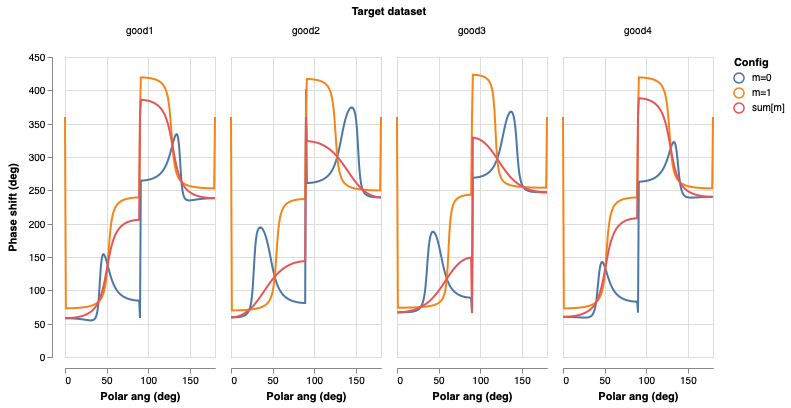

In [3]:
generated["Polar ang (deg)"] = generated["Polar ang (rad)"] / np.pi * 180
generated["Phase shift (deg)"] = generated["Phase shift (rad)"] / np.pi * 180

alt.Chart(generated).mark_line().encode(
    x="Polar ang (deg)",
    y="Phase shift (deg)",
    color="Config",
    column="Target dataset",
).properties(width=150)

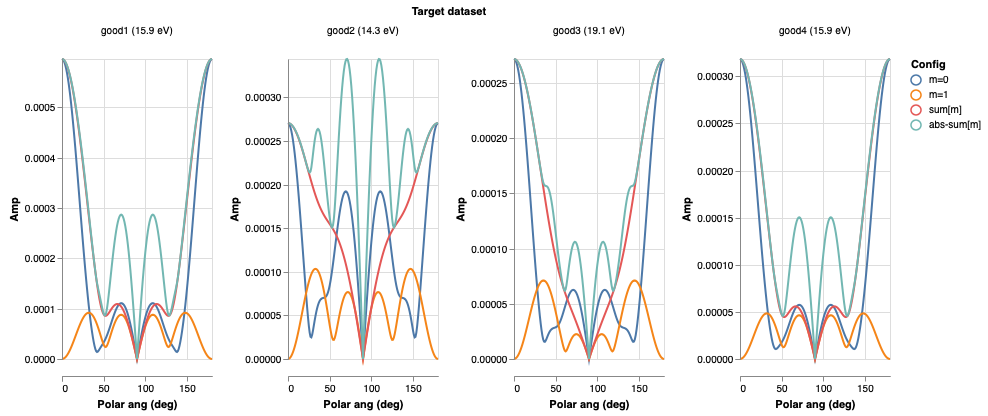

In [8]:
def f(df: pd.DataFrame) -> pd.DataFrame:
    amps = df["Amp"].reset_index(level=0, drop=True)
    return pd.DataFrame({
        "m=0": amps["m=0"],
        "m=1": amps["m=1"],
        "sum[m]": amps["sum[m]"],
        "abs-sum[m]": amps["m=0"] + 2 * amps["m=1"],
#         "sum[m] / abs-sum[m]": amps["sum[m]"] / (amps["m=0"] + 2 * amps["m=1"]),
#         "m=1 / m=0": amps["m=1"] / amps["m=0"],
    })


flatten = (
    generated
    .set_index(["Target dataset", "Config", "Polar ang (deg)"])
    .groupby(["Target dataset"])
    .apply(f)
    .reset_index()
    .melt(id_vars=["Target dataset", "Polar ang (deg)"], var_name="Config", value_name="Amp")
    .replace({
        "good1": "good1 (15.9 eV)",
        "good2": "good2 (14.3 eV)",
        "good3": "good3 (19.1 eV)",
        "good4": "good4 (15.9 eV)",
    })
)

(
    alt.Chart(flatten).mark_line().encode(
        x="Polar ang (deg)",
        y=alt.Y("Amp", scale=alt.Scale(nice=False)),
        color=alt.Color("Config", scale=alt.Scale(domain=["m=0", "m=1", "sum[m]", "abs-sum[m]"])),
    )
    .properties(width=150)
    .facet(column="Target dataset")
    .resolve_scale(y="independent")
)

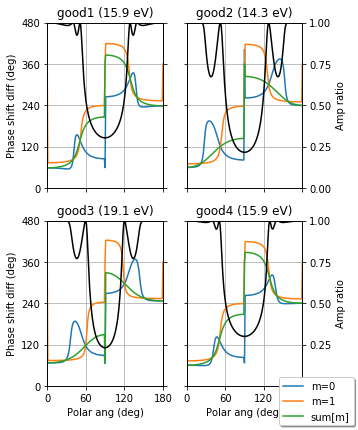

In [5]:
def _ratio(df: pd.DataFrame):
    amp = {m: a for _, m, a in df[["Config", "Amp"]].itertuples()}
    sum_ = amp["m=0"] + 2 * amp["m=1"]
    if sum_ == 0:
        return np.nan
    # return amp["m=0"] / sum_
    return amp["sum[m]"] / sum_


plt.figure(figsize=(5, 6))
for i, (k, g) in enumerate(generated.groupby("Target dataset")):
    plt.subplot(2, 2, i + 1)
    plt.xlabel("Polar ang (deg)")
    plt.ylabel("Phase shift diff (deg)")
    ph = g["Photon energy (eV)"].iloc[0]
    plt.title(f"{k} ({ph} eV)")
    for m, df in g.groupby("Config"):
        plt.plot(df["Polar ang (rad)"] / np.pi * 180,
                 df["Phase shift (rad)"]/ np.pi * 180,
                 label=m)
    plt.grid(True)
    if i == 0:
        plt.figlegend(loc="lower right", shadow=True)
    plt.xlim(0, 180)
    plt.ylim(0, 480)
    plt.xticks([0, 60, 120, 180])
    plt.yticks([0, 120, 240, 360, 480])
    plt.gca().label_outer()
    
    plt.twinx()
    plt.ylabel("Amp ratio")
    r = g.groupby("Polar ang (rad)").apply(_ratio)
    plt.plot(r.index / np.pi * 180, r, "k")
    plt.ylim(0, 1)
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    if i in {0, 2}:
        plt.setp(plt.gca().yaxis.get_label(), visible=False)
        plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.tight_layout()
# plt.savefig("Figures/Ne phase shift diffs - TDCASSCF - From partial waves.pdf")

In [6]:
def _average(df: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "Phase shift (rad)": df["Phase shift (rad)"].mean(),
        "Photon energy (eV)": df["Photon energy (eV)"].iloc[0],
        "Config": df["Config"].iloc[0],
        "Polar ang (rad)": df["Polar ang (rad)"].iloc[0],
    })


def _sloop(df: pd.DataFrame) -> pd.DataFrame:
    x = df["Photon energy (eV)"].values
    index = pd.Index(x[:-1], name="Photon energy fr (eV)")
    dx = 2 * np.diff(x)
    dy = np.diff(df["Phase shift (rad)"])
    k = 24.1888432651 / 0.0367493
    return pd.DataFrame({
        "EWS delay (as)": dy / dx * k,
        "Photon energy fr (eV)": x[:-1],
        "Photon energy to (eV)": x[1:],
        "Config": df["Config"].iloc[0],
        "Polar ang (rad)": df["Polar ang (rad)"].iloc[0],
    }, index=index)


diff = (
    generated
    .groupby(["Photon energy (eV)", "Config", "Polar ang (rad)"])
    .apply(_average)
    .sort_index()  # Sort by photon energies
    .reset_index(drop=True)
    .groupby(["Config", "Polar ang (rad)"])
    .apply(_sloop)
)
diff.head()

EWS delay (as)  \
Config Polar ang (rad) Photon energy fr (eV)                   
m=0    0.000000        14.3                        -0.690889   
                       15.9                        13.931515   
       0.017453        14.3                        -0.719304   
                       15.9                        13.939281   
       0.034907        14.3                        -0.805150   

                                              Photon energy fr (eV)  \
Config Polar ang (rad) Photon energy fr (eV)                          
m=0    0.000000        14.3                                    14.3   
                       15.9                                    15.9   
       0.017453        14.3                                    14.3   
                       15.9                                    15.9   
       0.034907        14.3                                    14.3   

                                              Photon energy to (eV) Config  \
Config Polar ang (rad) Photon energy fr (eV)                                 
m=0    0.000000        14.3                                    15.9    m=0   
                       15.9                                    19.1    m=0   
       0.017453        14.3                                    15.9    m=0   
                       15.9                                    19.1    m=0   
       0.034907        14.3                                    15.9    m=0   

                                              Polar ang (rad)  
Config Polar ang (rad) Photon energy fr (eV)                   
m=0    0.000000        14.3                          0.000000  
                       15.9                          0.000000  
       0.017453        14.3                          0.017453  
                       15.9                          0.017453  
       0.034907        14.3                          0.034907

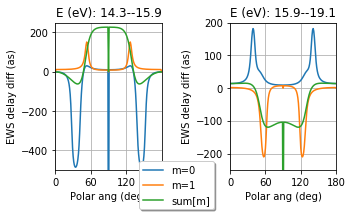

In [7]:
ylim = {14.3: (-500, 250), 15.9: (-250, 200)}

plt.figure(figsize=(5, 3))
for i, (j, g) in enumerate(diff.reset_index(drop=True).groupby("Photon energy fr (eV)")):
    plt.subplot(1, 2, i + 1)
    plt.title("E (eV): {}--{}".format(g["Photon energy fr (eV)"].iloc[0],
                                      g["Photon energy to (eV)"].iloc[0]))
    plt.xlabel("Polar ang (deg)")
    plt.ylabel("EWS delay diff (as)")
    for m, df in g.groupby("Config"):
        plt.plot(df["Polar ang (rad)"] / np.pi * 180,
                 df["EWS delay (as)"],
                 label=m)
    plt.grid(True)
    plt.xlim(0, 180)
    plt.ylim(*ylim[j])
    if i == 0:
        plt.figlegend(loc="lower center", shadow=True)
    plt.locator_params(axis='x', steps=[1, 3, 6])
plt.tight_layout()
plt.savefig("Figures/EWS delays at each m TDCASSCF.pdf")